In [32]:
import numpy as np
import matplotlib.pyplot as plt

# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()


In [33]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']


In [34]:
type(spike_times)
spike_times.shape

idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

# different sizes of 1D arrays in an array, each array corresponds to each of the 734 neurons and each element corresponds to the spike time

n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

<class 'numpy.ndarray'>
(826,)
<class 'numpy.ndarray'>
(9723,)
Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


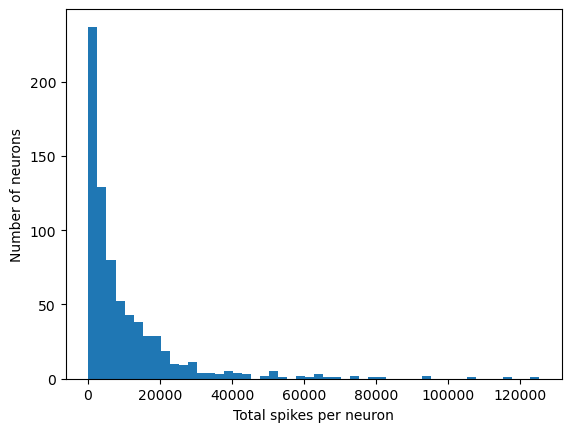

In [35]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

In [36]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


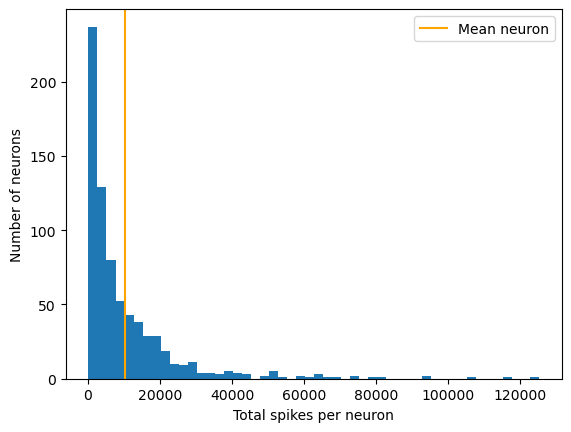

In [37]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

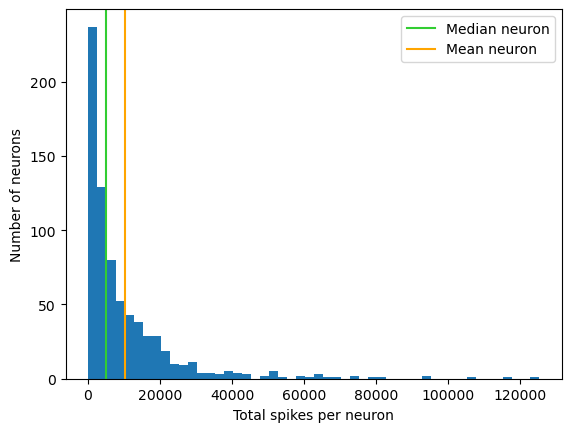

In [38]:
# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)  # Hint: Try the function np.median

# Visualize median, mean, and histogram
plt.hist((total_spikes_per_neuron), bins=50, histtype="stepfilled")
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()

In [39]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")


spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.33% of the total spikes are in the interval
0.37% of the total time is in the interval


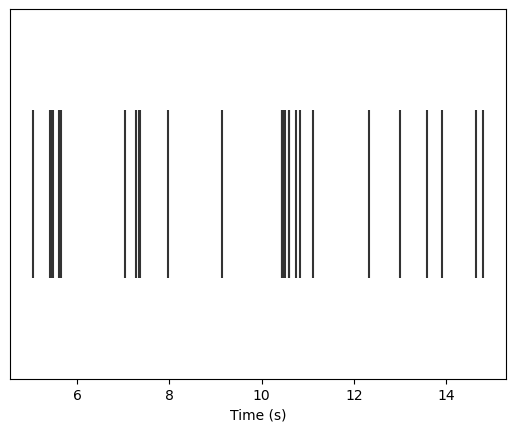

In [40]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

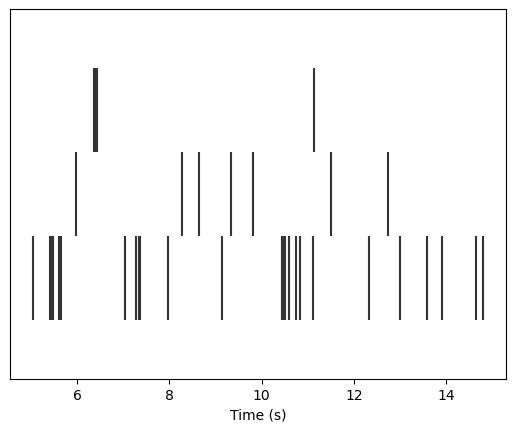

In [41]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

# This is called a raster plot.

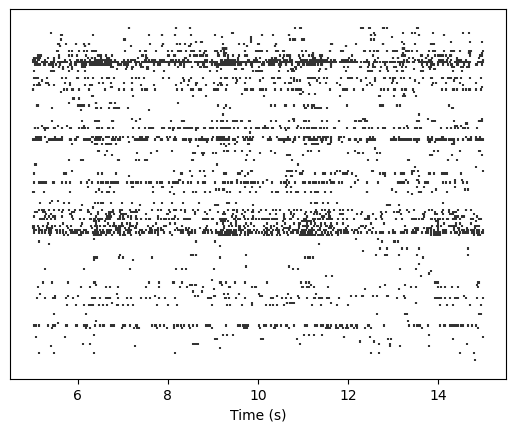

In [42]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

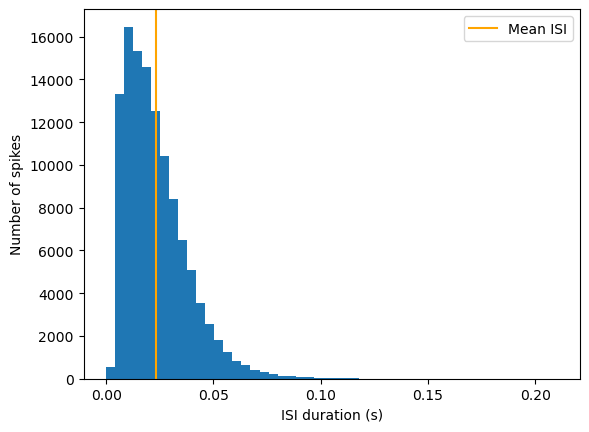

In [43]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """

  # Extract the spike times for the specified neuron
  single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(single_neuron_spikes)

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

We are gonna use a Linear IF Neuron, which is a point neuron. That is to say, a neuron's membrane potential is represented as a single number. Assuming the input current over a timestep is due to equal contributions from a non-negative integer number of input spikes arriving in that timestep, we can use a Poisson distribution.

In [44]:
# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

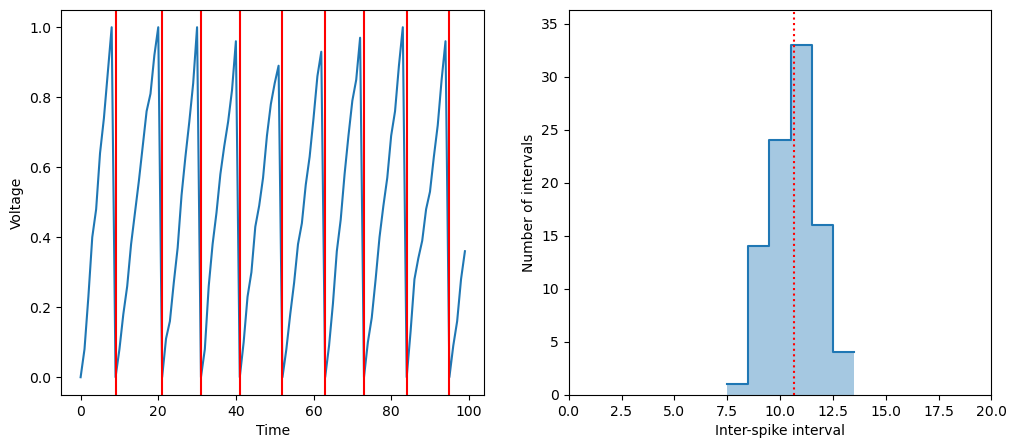

In [45]:
from scipy import stats

def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  # Precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps) # rate is the parameter alpha, .rvs(n_steps) generates n_steps number of random samples

  # Initialize voltage and spike storage
  v = np.zeros(n_steps)
  spike_times = []

  # Loop over steps
  for i in range(1, n_steps):

    # Update v
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv

    # If spike happens, reset voltage and record
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
plot_neuron_stats(v, spike_times)

Now we use Leaky IF Neuron

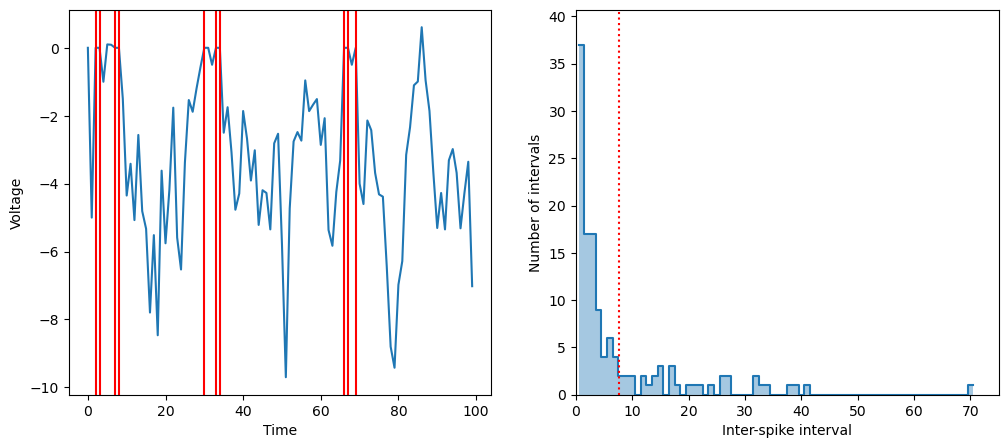

In [46]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """

  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
plot_neuron_stats(v, spike_times)

The fact that the output ISI distribution looks like exponential function implies that the input ISI distribution would also look the same. So in the brain, the input must look just like the outputs.

And over the period of an integration window, there is a certain probability that it would reach a threshold. And since every window is independent, the probability is multiplied. That is why it looks exponential

In [47]:
# @title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range)
  plt.ylim([0, ymax])


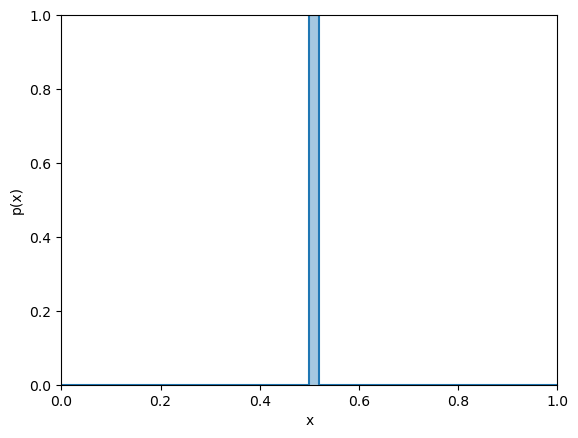

In [48]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

In [49]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """


  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = pmf[(pmf > 0)]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf * np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


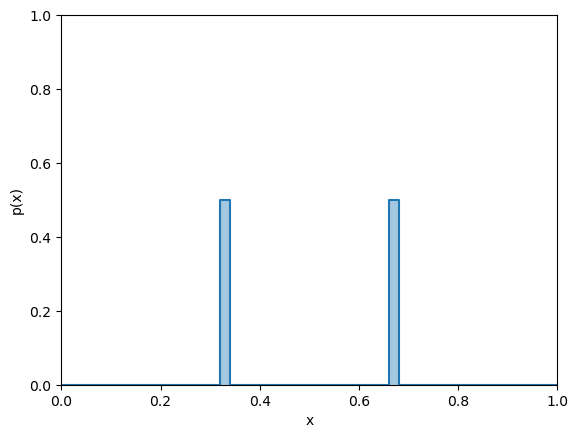

1.00 bits


In [50]:
# @markdown Execute this cell to visualize a PMF with split mass

pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

There is 1 bit of entropy. This means that before we take a random sample, there is 1 bit of uncertainty about which point in the distribution the sample will fall on: it will either be the first peak or the second one.

Likewise, if we make one of the peaks taller (i.e. its point holds more of the probability mass) and the other one shorter, the entropy will decrease because of the increased certainty that the sample will fall on one point and not the other

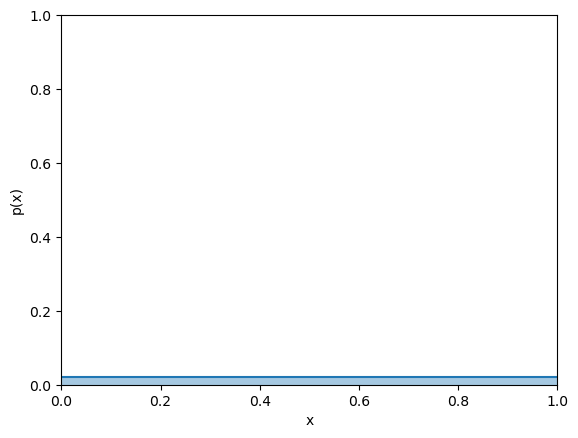

5.64 bits


In [51]:
# @markdown Execute this cell to visualize a PMF of uniform distribution

pmf = np.ones(n_bins) / n_bins  # [1/N] * N

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

Fixing the mean of the ISI distribution is equivalent to fixing its inverse: the neuron’s mean firing rate. If a neuron has a fixed energy budget and each of its spikes has the same energy cost, then by fixing the mean firing rate, we are normalizing for energy expenditure. This provides a basis for comparing the entropy of different ISI distributions. In other words: if our neuron has a fixed budget, what ISI distribution should it express (all else being equal) to maximize the information content of its outputs?

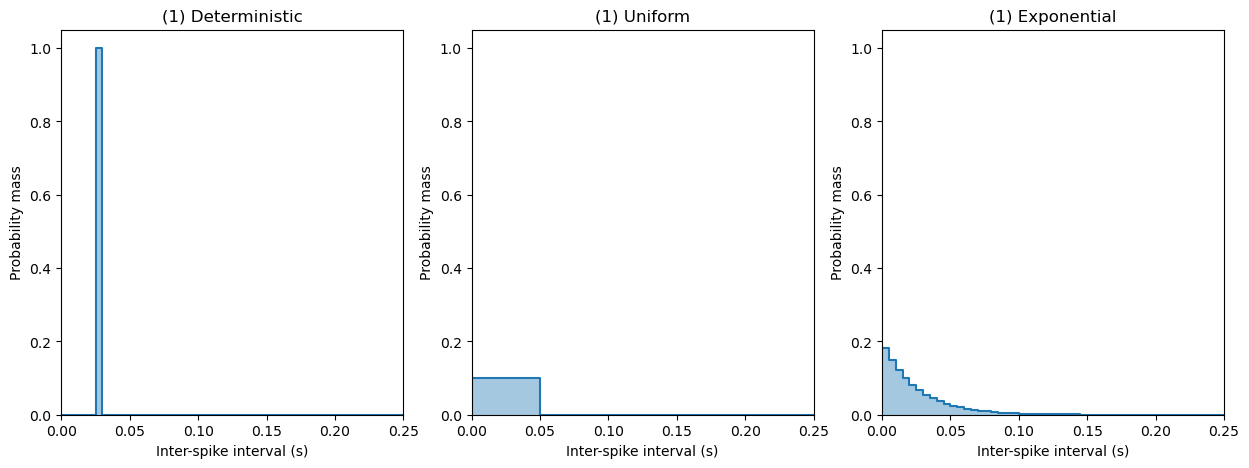

0.00 bits
3.32 bits
3.77 bits


In [52]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

# @markdown Run this cell to plot the three PMFs
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range)
  ax.set_ylim(ylim)
plt.show()

# Call entropy function and print result
print(f"{entropy(pmf_single):.2f} bits")
print(f"{entropy(pmf_uniform):.2f} bits")
print(f"{entropy(pmf_exp):.2f} bits")

In [55]:
#@title Download Data
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Could not download data')
else:
  steinmetz_spikes = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

3.36 bits
0.02
0.16662766206412358


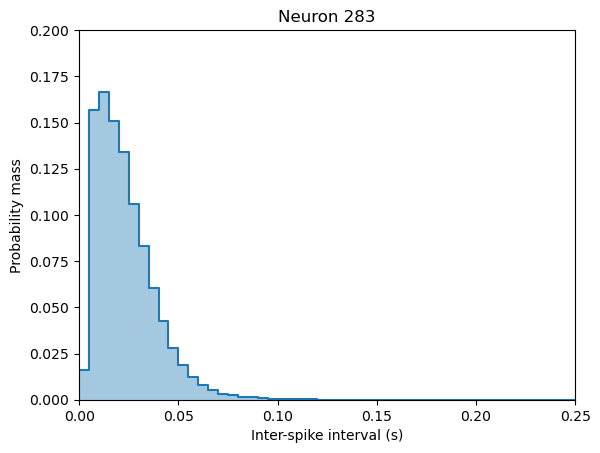

In [68]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""

  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf, isi_range)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")
print(np.mean(pmf))
print(np.max(pmf))

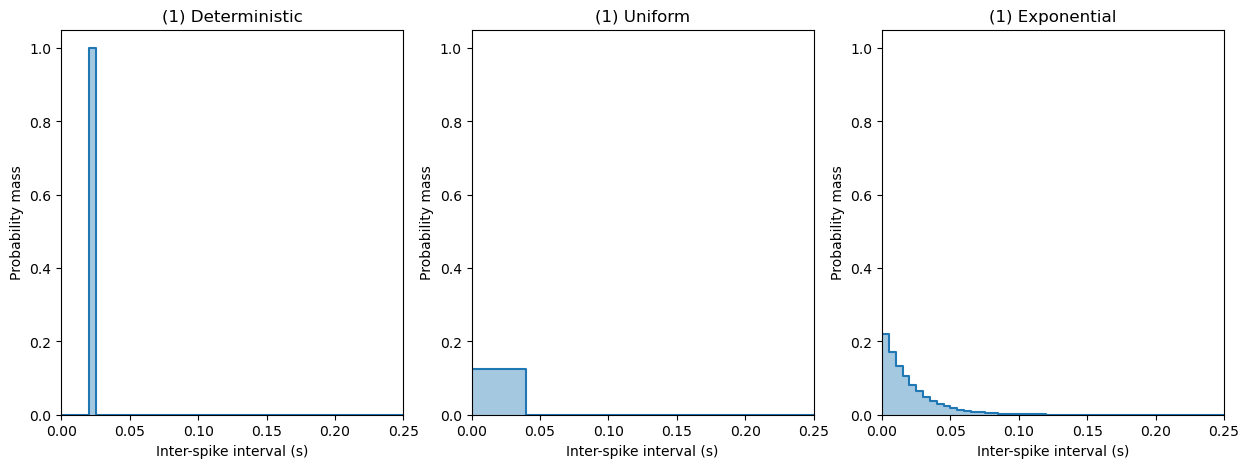

0.00 bits
3.00 bits
3.45 bits


In [69]:
n_bins = 50
mean_isi = 0.02
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

# @markdown Run this cell to plot the three PMFs
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range)
  ax.set_ylim(ylim)
plt.show()

# Call entropy function and print result
print(f"{entropy(pmf_single):.2f} bits")
print(f"{entropy(pmf_uniform):.2f} bits")
print(f"{entropy(pmf_exp):.2f} bits")

The real neuron ISI has entropy higher than uniform, lower than exponential. We can show analytically why the exponential distribution has the highest entropy given the constraint.

INTUITION

The mean is fixed to some specific value. Which means that if we want to increase the entropy by making the right hand side (higher ISI) have higher probability, the left hand side probability gets too smaller. So it is effecient to make the left hand side (lower ISI) have higher probability. Hence the skewness.